## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# first way: nunique
df['user_id'].nunique()

290584

In [5]:
# second way: drop duplicates and count them
unique_users = df['user_id'].drop_duplicates()
len(unique_users)

290584

d. The proportion of users converted.

In [6]:
df.converted.sum() / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# subtract from all user those where new_page and treatment shows together
df['user_id'].count() - df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# I will group the data with the groupby function by 'group' column and check the values of the converted column.
df2.groupby(['group']).converted.mean()

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

see above (0.118807)

d. What is the probability that an individual received the new page?

In [17]:
# probability for landing page values
df2.landing_page.value_counts()/df2.shape[0]

new_page    0.500064
old_page    0.499936
Name: landing_page, dtype: float64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**I find that the control group (users who received the old page) have a littlebit higher conversion rate than the treatment group (users with the new page). But the difference is only 0.0016, which is so small that it does not seem to be significant.** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The $H_{0}$ or null hypothesis is to keep the status quo. So it is that the old page is better or as good as the new page. (It has a higher conversion rate). The $H_{1}$ or alternative hypothesis is that the new page is better.**

**With formula:**

**Part II Hypothesis:**

  $$H_0: p_{new} - p_{old} <= 0$$

  $$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959667567149027

c. What is $n_{new}$?

In [20]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145311

d. What is $n_{old}$?

In [21]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, (1- p_new)])
len(new_page_converted)

145311

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, (1- p_old)])
len(old_page_converted)

145274

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

0.0013736894049302256

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
simulated_new_converted = np.random.binomial(n_new, p_new, 10000)/n_new
simulated_old_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = simulated_new_converted - simulated_old_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([3.000e+00, 2.200e+01, 2.410e+02, 1.068e+03, 2.512e+03, 3.102e+03,
        2.149e+03, 7.390e+02, 1.470e+02, 1.700e+01]),
 array([-0.00526833, -0.00428272, -0.00329711, -0.00231151, -0.0013259 ,
        -0.0003403 ,  0.00064531,  0.00163092,  0.00261652,  0.00360213,
         0.00458774]),
 <a list of 10 Patch objects>)

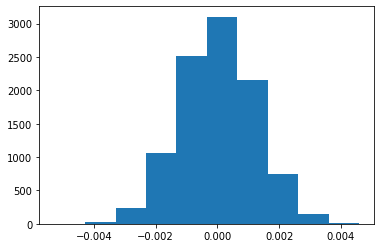

In [26]:
plt.hist(p_diffs)

This histogram looks like a normal distribution and that is what I expected. If we have large enough sample size then the sample distribution of the mean will be normally distributed because of the Central Limit Theorem.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# first calculate the actual difference between means
actual_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
actual_diff

-0.0015790565976871451

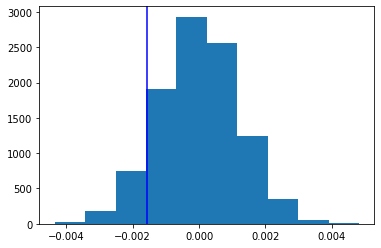

In [28]:
# create a random normal distribution centered at 0 with the same spread and size
nullvals = np.random.normal(0, p_diffs.std(), 10000)
plt.hist(nullvals)
plt.axvline(actual_diff, color='blue')

In [29]:
(nullvals > actual_diff).mean()

0.9021

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The p-value was calculated here. This value helps us to decide whether we can reject the null hypothesis or not. A very small p-value means that an extreme observed outcome would be very unlikely under the null hypothesis. Our pre-defined threshold value alpha (level of significance) was 0.05 and since we got 0.9, which is higher than 0.05, this means that we fail to reject the null hypothesis. (p >= alpha) In fact, this was much-much higher than 0.05 so I wasn't even close to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group =='control'"))
n_new = len(df2.query("group =='treatment'"))

print('Conversion rate for old page: ', convert_old)
print('Conversion rate for new page: ', convert_new)
print('Number of rows (old page): ', n_old)
print('Number of rows (new page): ', n_new)

Conversion rate for old page:  17489
Conversion rate for new page:  17264
Number of rows (old page):  145274
Number of rows (new page):  145311


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
# calculate z_score and p_value with stat module proportions_ztest
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

print('Z-score: ', z_score)
print('P-value: ', p_value)

Z-score:  1.3116075339133115
P-value:  0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-score shows how many standard deviations an element is from the mean. The Z-score here is 1.31. Our p-value is 0.90, so we got very similar result that before that we fail to reject the null hypothesis. It concludes that the new page is not better than the old page. And this was the expected result.**

https://www.statisticshowto.com/probability-and-statistics/z-score/

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
df2['intercept'] = 1

df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.rename(columns = {'treatment': 'ab_page'}, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
y = df2['converted']
X = df2[['intercept', 'ab_page']]

# instantiate the logistic regression model
logistic_regression = sm.Logit(y, X)

# fit the model
results = logistic_regression.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Sep 2020   Pseudo R-squ.:               8.085e-06
Time:                        18:37:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Part III Hypothesis:**

  $$H_0: p_{new} - p_{old} = 0$$

  $$H_1: p_{new} - p_{old} \neq 0$$
  
The p-value associated with Part III is different from Part II. It's not surprising because we state a different hypothesis here. 
In Part II we are asking whether the conversion rate for the new page is greater than the old page. In Part III we are asking whether there is a difference in conversion rate between the new page and the old page. Here the P-value of 0.19 results that we fail to reject the null hypothesis. (So there is no significant difference in conversion rate between the old and the new page.) So we asked different questions but we concluded a similar result.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We should consider other factors into the regression model since they can influence conversions too. We can add the time duration the users spent on the page. The more time the customer spends, the more likely to get engaged. Seasonality can also be an important factor. Location can be useful to consider too, etc.**
**However, many additional terms could mislead and confuse the analysis. Too many factors could result that more term has a less significant impact on the outcome. The best way to decide is to stick to those parameters that have a big impact on the conversion rate.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


In [38]:
# let's check the number of the different country values
df_new.country.value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

# I will need only two columns for the three dummy variables, so drop the third one
df_new = df_new.drop(['US'], axis=1)

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,0


In [40]:
### Fit Your Linear Model And Obtain the Results

y2 = df_new['converted']
X2 = df_new[['intercept', 'CA', 'UK']]

# instantiate the logistic regression model
logistic_regression2 = sm.Logit(y2, X2)

# fit the model
results2 = logistic_regression2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.0880
Date:               2020-09-16 18:37 BIC:              212812.8269
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.19834    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3154  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5176  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7462  0.4555  -0.0161   0.0360
==================================================================

"""

There is a close relationship between confidence intervals and significance tests. Specifically, if a statistic is significantly different from 0 at the 0.05 level, then the 95% confidence interval will not contain 0. All values in the confidence interval are plausible values for the parameter, whereas values outside the interval are rejected as plausible values for the parameter. Here country does not have impact on conversion. Both p_value for CA and UK is not statistically significant, their confidence interval contains 0. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
### Fit Your Linear Model And Obtain the Results

y3 = df_new['converted']
X3 = df_new[['intercept', 'ab_page', 'CA', 'UK']]

# instantiate the logistic regression model
logistic_regression3 = sm.Logit(y3, X3)

# fit the model
results3 = logistic_regression3.fit()
results3.summary2()


Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.3782
Date:               2020-09-16 18:37 BIC:              212823.6968
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.17584    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
UK            0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

<a id='conclusions'></a>
## Conclusions


If we are including both the page and country into the model, it still doesn't have a significant effect on conversion. All the p_value for the page, the CA, and the UK column is not statistically significant, their confidence interval contains 0. 
In a conclusion, I can say that there is no evidence that the new page would work better than the old page, so we fail to reject the null hypothesis.


Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.